In [1]:
# Reference paper:
# Duarte 2018, Gradient-Based Structural Estimation (working paper)

In [2]:
# Import libraries
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
import tensorflow_probability as tfp
%matplotlib inline

In [3]:
# Terminal date
T = 9

# Network design and optization hyperparameters
batch_size = 5000

optimizer = tf.keras.optimizers.Adam()

state_size = 3


# function that creates a network
def net():
    model = Sequential([Dense(64, 'relu', input_shape=(state_size,)),
                        Dense(64, 'relu'),
                        Dense(1, 'sigmoid')])
    return model


n = [net() for _ in range(T)]
Θ = [n[t].weights for t in range(T)]
Θ = [item for sublist in Θ for item in sublist]

In [4]:
# %% Economic Model ------------------------------------------------------

# Model parameters
σ_ε = 0.02058
λ_ε = 0.99
β = .97

def sample_γ(shape):
    return tf.random.uniform(shape, minval=1.2, maxval=5)

# Prices
r = 0.07
w = 5

μx = 2.
σx = 1.

μe = 0.
σe = .14

μγ = 3.
σγ = 1.

def u(C, γ):
    return C**(1 - γ) / (1 - γ)


def normalize(x, e, γ):
    x = (x - μx) / σx
    e = (e - μe) / σe
    γ = (γ - μγ) / σγ

    X = tf.concat([x, e, γ], 1)
    return X


def simulate(return_results=False):
    x0 = tf.random.uniform([batch_size, 1], minval=.01, maxval=4)
    e0 = tf.random.uniform([batch_size, 1], minval=-.25, maxval=.25)
    γ = sample_γ([batch_size, 1])

    # Normal shock at t=0
    def ε():
        return tf.random.normal(shape=[batch_size, 1])

    # Organize variables and shocks in dictionaries
    x = {0: x0}
    e = {0: e0}
    s = {}
    y = {}
    C = {}

    for t in range(T):
        # The inputs of the network are wealth and productivity at t
        X = normalize(x[t], e[t], γ)
        s[t] = n[t](X)

        # Disposable income
        y[t] = (1 + r) * x[t] + tf.exp(e[t]) * w

        # Consumption
        C[t] = (1 - s[t]) * y[t]

        # Next states
        e[t + 1] = λ_ε * e[t] + σ_ε * ε()
        x[t + 1] = s[t] * y[t]

    # Terminal values
    C[T] = (1 + r) * x[T] + tf.exp(e[T]) * w

    V = sum([β**t * u(C[t], γ) for t in range(T + 1)])
    
    if return_results:
        return -V, [x, e, γ]
    else:
        return -V


@tf.function
def training_step():
    optimizer.minimize(simulate, Θ)

In [6]:
n_iterations = 10000
for iteration in range(n_iterations):
    training_step()
    if iteration % 1000 == 0:
        print(str((iteration) / n_iterations * 100) + '%')

0.0%
10.0%
20.0%
30.0%
40.0%
50.0%
60.0%
70.0%
80.0%
90.0%


In [10]:
xgrid = np.load('xgrid.npy')
C = np.load('C.npy')


def plot(γ_=2.):
    V, results = simulate(return_results=True)
    
    def plot_one(t, color):
        xt = results[0][t]
        et = tf.zeros_like(xt)
        γ = γ_ * tf.ones_like(xt)

        X = normalize(xt, et, γ)
        s = n[t](X)

        # Disposable income
        y = (1 + r) * xt + tf.exp(et) * w

        # Consumption
        C = (1 - s) * y

        plt.scatter(xt, C, s=1, color=color)

    plot_one(t=0, color='b')
    plot_one(t=3, color='r')
    plot_one(t=6, color='g')

    plt.plot(xgrid, C[0, :, 10], color='k')
    plt.plot(xgrid, C[3, :, 10], color='k')
    plt.plot(xgrid, C[6, :, 10], color='k')

    plt.show()
    plt.pause(1e-9)

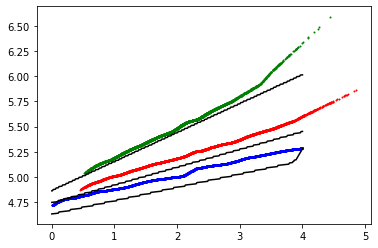

In [15]:
plot(γ_=2)